In [1]:
from qml_contrastive.data_jets_graph import *

Length: 100000, Info: Data(y=[1], pid=[18, 1], h=[18, 3]), Sample...: 
tensor([[ 5.3666e-04,  3.8694e-01, -8.9608e-03],
        [ 3.1963e-04, -2.2557e-01, -2.0012e-01],
        [ 2.2936e-03, -3.2403e-02, -2.4649e-01],
        [ 8.2497e-03,  2.0372e-01,  1.5876e-02],
        [ 3.3865e-03, -1.8214e-01,  4.6523e-02]])
Data(y=[1], pid=[27, 1], h=[27, 3], edge_index=[2, 702])
Node degree: 26.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'h', 'y', 'pid', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


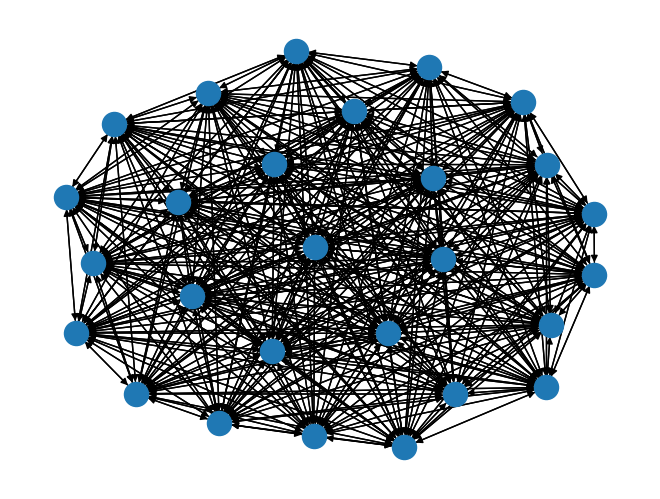

In [2]:
dataset = QG_Jets('../data/QG_Jets')
print(f"Length: {len(dataset)}, Info: {dataset[0]}, Sample...: \n{dataset[0].h[:5]}")


total_size = 100000

train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = int(0.2 * total_size)

dataset.transform = KNNGroup(k=50, attr_name="h")
sample = dataset[10]
print(sample)

print(f'Node degree: {sample.num_edges / sample.num_nodes:.2f}')
print(f'Has isolated nodes: {sample.has_isolated_nodes()}')
print(f'Has self-loops: {sample.has_self_loops()}')
print(f'Is undirected: {sample.is_undirected()}')
nx.draw(pyg.utils.to_networkx(dataset[10]))

In [3]:
class Custom_GCN(pyg_nn.MessagePassing):
    def __init__(self, out_channels, in_channels=8):
        super().__init__(aggr='add')

        self.mlp = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels),
        )

    def forward(self, h, pid, edge_index):
        # Start propagating messages.
        return self.propagate(edge_index, h=h, pid=pid)

    def message(self, h_i, h_j, pid_i, pid_j):
        # h_j: The features of neighbors as shape [num_edges, in_channels]
        # pid_j: The pid of neighbors as shape [num_edges, pos_dim]
        # # ...
        # print(h_i, h_j, pid_i, pid_j)
        edge_feat = torch.cat([h_i, h_j, pid_i, pid_j], dim=-1)
        return self.mlp(edge_feat)
    
class GCN_Encoder(nn.Module):
    def __init__(self, hidden_dim=8):
        super().__init__()

        self.conv1 = Custom_GCN(hidden_dim)
        self.conv2 = Custom_GCN(hidden_dim*2, in_channels=hidden_dim*2+2)
        # self.classifier = pyg_nn.MLP([hidden_dim, hidden_dim, output_dim], bias=[False, True])

    def forward(self, data):
        h, pid, edge_index, batch = data.h, data.pid, data.edge_index, data.batch
        
        # First Custom_GCN layer
        x = self.conv1(h=h, pid=pid, edge_index=edge_index)
        x = x.relu()
        # x = self.dropout(x)
        
        # Second Custom_GCN layer
        x = self.conv2(h=x, pid=pid, edge_index=edge_index)
        x = x.relu()
        # x = self.dropout(h)
        
        # Global Pooling:
        x = pyg_nn.global_mean_pool(x, batch)
        
        # Classifier:
        # return self.classifier(x)
        return x

import pytorch_lightning as pl    
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device:", device)
batch_size = 64
from pytorch_metric_learning import losses
import torchmetrics

class ModelPL(pl.LightningModule):
    def __init__(self, model, learning_rate=0.01):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = losses.ContrastiveLoss(pos_margin=0.25, neg_margin=1.5)

        self.train_loss = torchmetrics.MeanMetric()
        self.val_loss = torchmetrics.MeanMetric()

    def forward(self, data):
        return self.model(data)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=1),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, data, batch_idx):
        embeddings = self(data)
        loss = self.criterion(embeddings, data.y)
        self.train_loss.update(loss)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        return loss

    def validation_step(self, data, batch_idx):
        embeddings = self(data)
        loss = self.criterion(embeddings, data.y)
        self.val_loss.update(loss)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        return loss

    def test_step(self, data, batch_idx):
        embeddings = self(data)
        loss = self.criterion(embeddings, data.y)
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        return loss


Device: cuda


In [4]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = pyg_loader.DataLoader(train_dataset, batch_size=batch_size, num_workers = 12)
val_loader = pyg_loader.DataLoader(val_dataset, batch_size=batch_size, num_workers = 12)
test_loader = pyg_loader.DataLoader(test_dataset, batch_size=batch_size, num_workers = 12)

GCN_Encoder = GCN_Encoder()

Contrastive_Graph_pl = ModelPL(model=GCN_Encoder, learning_rate=0.01)

logger = pl.loggers.CSVLogger(save_dir='logs', name='Contrastive_Graph_pl', version=0)

summary_callback = pl.callbacks.ModelSummary(max_depth=8)
callbacks = [summary_callback]

trainer_dynGCNN = pl.Trainer(max_epochs=15, 
                            accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                            callbacks=callbacks,
                            logger=logger,)

train_result = trainer_dynGCNN.fit(Contrastive_Graph_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
test_result = trainer_dynGCNN.test(dataloaders=test_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                                | Type              | Params
---------------------------------------------------------------------------
0  | model                               | GCN_Encoder       | 720   
1  | model.conv1                         | Custom_GCN        | 144   
2  | model.conv1.aggr_module             | SumAggregation    | 0     
3  | model.conv1.mlp                     | Sequential        | 144   
4  | model.conv1.mlp.0                   | Linear            | 72    
5  | model.conv1.mlp.1                   | ReLU              | 0     
6  | model.conv1

Sanity Checking: 0it [00:00, ?it/s]

/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'h', 'y', 'pid', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(
/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'h', 'y', 'pid', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(
/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'h', 'y', 'pid', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(
/home/ubuntu20_1/Miniconda3/envs/py39_qml/l

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'h', 'y', 'pid', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


Epoch 0:   0%|          | 0/1251 [00:00<?, ?it/s]                          

/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'h', 'y', 'pid', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(
/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'h', 'y', 'pid', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(
/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'h', 'y', 'pid', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(
/home/ubuntu20_1/Miniconda3/envs/py39_qml/l

Epoch 0:  75%|███████▍  | 938/1251 [00:28<00:09, 32.61it/s, loss=1.36, v_num=0]

/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'h', 'y', 'pid', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(
/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'h', 'y', 'pid', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(
/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'h', 'y', 'pid', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(
/home/ubuntu20_1/Miniconda3/envs/py39_qml/l

Epoch 0:  76%|███████▌  | 949/1251 [00:29<00:09, 32.19it/s, loss=1.36, v_num=0]

RuntimeError: The expanded size of the tensor (2900) must match the existing size (2899) at non-singleton dimension 0.  Target sizes: [2900, 16].  Tensor sizes: [2899, 1]